# Forecasting Bike Hire Trips

### In this first step we read in the CSVs from the start of 2014 until the end of August in 2017.

Install upcoming version of _statsmodels_ because of conflict with scipy

In [1]:
!pip install statsmodels==0.10.0rc2

In [2]:
%matplotlib inline
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pylab import rcParams
import statsmodels.api as sm
import warnings
plt.style.use('fivethirtyeight')
rcParams['figure.figsize'] = 16, 8
warnings.filterwarnings("ignore")

In [3]:
time_start = dt.datetime(2014,1,1)
time_end = dt.datetime(2017,9,1,0,0,0)
station_start = 6184
station_end = 6015
days_in_year = 365
missing_data = {
    2014:[dt.datetime(2014,4,15), dt.datetime(2014,11,15)],
    2015:[dt.datetime(2015,4,15), dt.datetime(2015,11,15)],
    2016:[dt.datetime(2016,4,15), dt.datetime(2016,11,15)],
    2017:[dt.datetime(2017,4,15), dt.datetime(2017,11,15)]
}
valid_forecast_date = '2017-7-3'

method to read in one csv for each month and year to avoid putting all into RAM

In [4]:
def read_csv(year, month):
    file = os.path.join('data', f'BixiMontrealRentals{year}', f'OD_{year}-{month:02}.csv')
    df = pd.read_csv(file, parse_dates=['start_date', 'end_date'])
    df.sort_values(by=['start_date'], inplace=True)
    date_range = (df['start_date'] >= time_start) & (df['end_date'] < time_end)
    df = df.loc[date_range]
    route = (df['start_station_code'] == station_start) & (df['end_station_code'] == station_end)
    df = df.loc[route]
    member = df['is_member'] == 1
    df = df.assign(hire_memb=member, hire_non=~member)
    df.drop('is_member', axis=1, inplace=True)
    return df

In [5]:
df = pd.DataFrame()
for year in range(2014,2018):
    print(year)
    for month in range(1,13):
        try:
            df = df.append(read_csv(year, month))
        except FileNotFoundError:
            pass
df.sort_values(by=['start_date'], inplace=True)
df.set_index(['start_date'], inplace=True)

2014
2015
2016
2017


In [6]:
df.head(5)

,start_station_code,end_date,end_station_code,duration_sec,hire_memb,hire_non
start_date,,,,,,
2014-04-15 07:53:00,6184,2014-04-15 08:02:00,6015,517,True,False
2014-04-16 16:55:00,6184,2014-04-16 17:06:00,6015,686,True,False
2014-04-16 18:11:00,6184,2014-04-16 18:18:00,6015,439,True,False
2014-04-16 18:53:00,6184,2014-04-16 19:03:00,6015,580,True,False
2014-04-17 08:58:00,6184,2014-04-17 09:05:00,6015,412,True,False


### Now we can begin the forecast.

Three columns for daily count of hires: members, non-members, and total.

In [7]:
df_daily = pd.DataFrame()
df_daily = df.resample('D').agg({'hire_memb':'sum', 'hire_non':'sum'})
df_daily = df_daily.assign(hire_tot=df_daily['hire_memb']+df_daily['hire_non'])
df_daily.reset_index(inplace=True)

Put NaN values for regions with no data. 

In [8]:
invalid_dates = np.full(len(df_daily), True)
for year in range(2014, 2018):
    indices = (df_daily['start_date'] < missing_data[year][0]) | (df_daily['start_date'] > missing_data[year][1])
    invalid_dates = invalid_dates & indices
df_daily.loc[invalid_dates, ['hire_memb', 'hire_non', 'hire_tot']] = np.nan
df_daily.set_index(['start_date'], inplace=True)

Display a small region of the data .

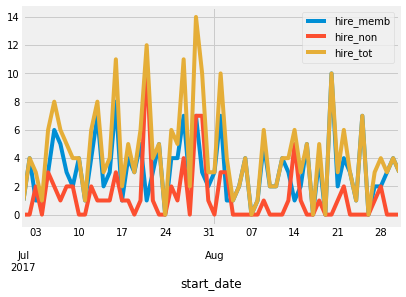

In [9]:
df_daily['2017-07':].plot(y=['hire_memb','hire_non','hire_tot'])

Seasonal decomposition plot for each dataset.

In [10]:
def decomposition_plot(hire):
    decomposition = sm.tsa.seasonal_decompose(df_daily[hire].dropna(), freq=days_in_year)
    decomposition.plot()
    plt.show()

hire_memb


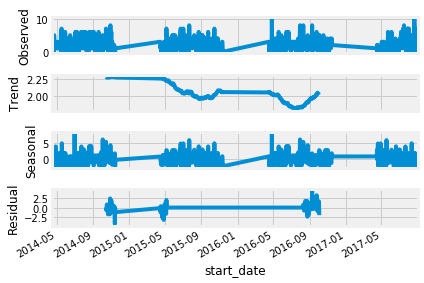






hire_non


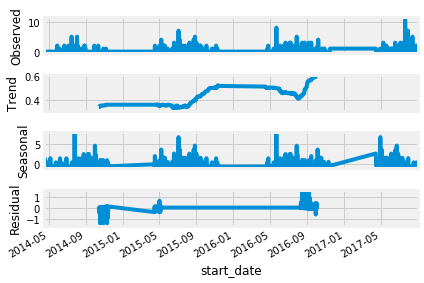






hire_tot


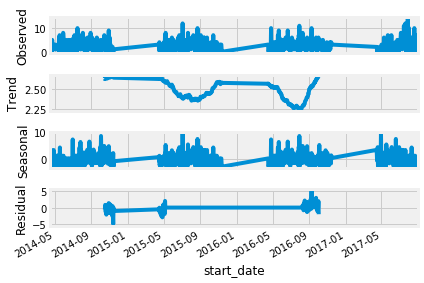

In [11]:
for hire in ['hire_memb', 'hire_non', 'hire_tot']:
    print(hire)
    decomposition_plot(hire)
    print('\n\n\n\n')

### ARIMA

We won't explore the parameter space of p, d, q here because it is very slow for daily data. Cannot encode seasonal order due to not enough data.

In [12]:
def sarimax(hire):
    mod = sm.tsa.statespace.SARIMAX(df_daily[hire],
                                    order=(7, 1, 7),
                                    freq='D',
                                    seasonal_order=(0, 0, 0, 0),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics()
    plt.show()
    return results

Plot validation forecast to check validity of prediction.

In [13]:
def validation_forecast(sarimax_results, hire):
    pred = sarimax_results.get_prediction(start=pd.to_datetime(valid_forecast_date), dynamic=False)
    pred_ci = pred.conf_int()
    ax = df_daily[hire]['2017-6':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='one-step ahead Forecast', alpha=.7)
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_ylabel(hire)
    plt.legend()
    plt.show()
    return pred

Determine the mean squared error of our prediction.

In [14]:
def mse_error(pred, hire):
    y_forecasted = pred.predicted_mean
    y_truth = df_daily[hire][valid_forecast_date:]
    mse = ((y_forecasted - y_truth) ** 2).mean()
    print(f'The Mean Squared Error of our forecasts is {mse:.2f}')
    print(f'The Root Mean Squared Error of our forecasts is {np.sqrt(mse):.2f}')

Perform the forecast on the first week in September.

In [15]:
def peform_forecast(sarimax_results, hire):
    pred_uc = sarimax_results.get_forecast(steps=10)
    pred_ci = pred_uc.conf_int()
    ax = df_daily[hire]['2017-8-14':].plot(label='observed')
    pred_uc.predicted_mean.plot(ax=ax, label='forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_ylabel(hire)
    plt.legend()
    plt.show()
    
    df_display = pred_ci
    df_display[f'mean {hire}'] = pred_uc.predicted_mean
    display(df_display['2017-09-04':].round(2))

We will consider hires by membrs, hires by non-members, and the total number of hires separately.

hire_memb
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3851      1.705     -0.226      0.821      -3.726       2.956
ar.L2         -0.6831      0.265     -2.581      0.010      -1.202      -0.164
ar.L3         -0.6976      1.115     -0.626      0.531      -2.883       1.488
ar.L4         -0.4704      0.998     -0.472      0.637      -2.426       1.485
ar.L5         -0.8431      0.401     -2.103      0.036      -1.629      -0.057
ar.L6         -0.3018      1.459     -0.207      0.836      -3.161       2.558
ar.L7          0.0279      0.055      0.508      0.611      -0.080       0.136
ma.L1         -0.5677      1.712     -0.332      0.740      -3.923       2.787
ma.L2          0.3133      1.573      0.199      0.842      -2.769       3.396
ma.L3          0.0851      1.104      0.077      0.939      -2.079       2.249
ma.L4         -0.2165      0.548     -0.39

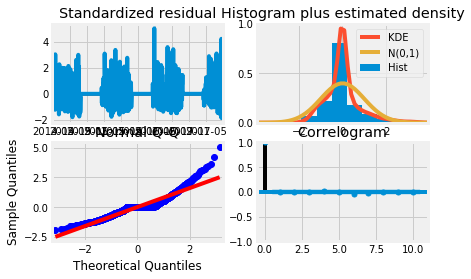

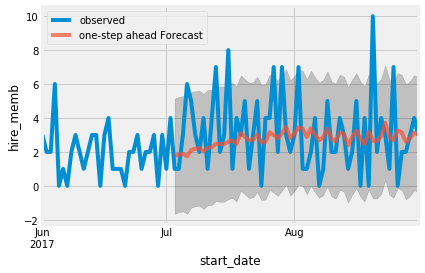

The Mean Squared Error of our forecasts is 5.06
The Root Mean Squared Error of our forecasts is 2.25


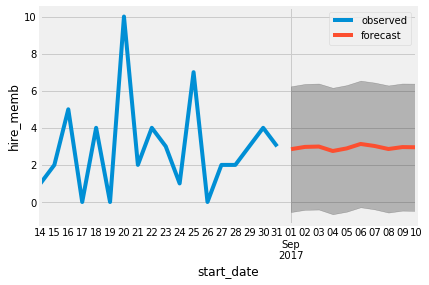

,lower hire_memb,upper hire_memb,mean hire_memb
2017-09-04,-0.66,6.16,2.75
2017-09-05,-0.52,6.30,2.89
2017-09-06,-0.28,6.54,3.13
2017-09-07,-0.40,6.44,3.02
2017-09-08,-0.57,6.28,2.86
2017-09-09,-0.47,6.39,2.96
2017-09-10,-0.48,6.38,2.95







hire_non
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5846      2.196     -0.266      0.790      -4.888       3.719
ar.L2         -1.2037      1.961     -0.614      0.539      -5.047       2.640
ar.L3         -0.3967      3.036     -0.131      0.896      -6.348       5.554
ar.L4         -0.4641      1.785     -0.260      0.795      -3.962       3.034
ar.L5         -0.2990      1.177     -0.254      0.799      -2.605       2.007
ar.L6          0.0778      0.921      0.084      0.933      -1.727       1.882
ar.L7         -0.0334      0.197     -0.170      0.865      -0.419       0.352
ma.L1         -0.3222      2.190     -0.147      0.883      -4.615       3.971
ma.L2          0.6620      0.447      1.480      0.139      -0.214       1.539
ma.L3         -0.7021      1.336     -0.526      0.599      -3.320       1.916
ma.L4          0.1471      1.216      

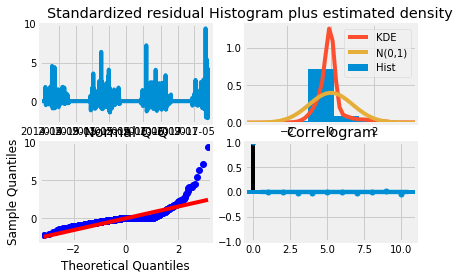

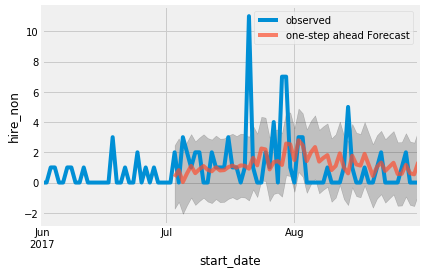

The Mean Squared Error of our forecasts is 4.28
The Root Mean Squared Error of our forecasts is 2.07


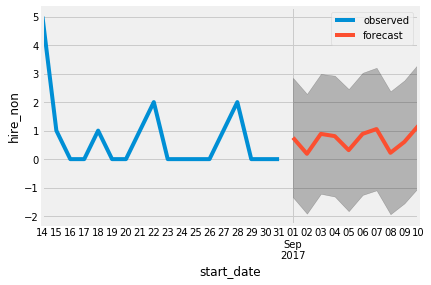

,lower hire_non,upper hire_non,mean hire_non
2017-09-04,-1.31,2.93,0.81
2017-09-05,-1.83,2.46,0.32
2017-09-06,-1.25,3.03,0.89
2017-09-07,-1.09,3.20,1.05
2017-09-08,-1.93,2.38,0.22
2017-09-09,-1.55,2.76,0.60
2017-09-10,-1.00,3.34,1.17







hire_tot
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1334      1.049     -0.127      0.899      -2.190       1.923
ar.L2         -0.5191      0.481     -1.079      0.281      -1.462       0.424
ar.L3         -0.1581      0.673     -0.235      0.814      -1.477       1.161
ar.L4         -0.2043      0.404     -0.506      0.613      -0.996       0.587
ar.L5         -0.5052      0.313     -1.615      0.106      -1.118       0.108
ar.L6         -0.4043      0.725     -0.558      0.577      -1.825       1.016
ar.L7          0.0213      0.099      0.215      0.830      -0.173       0.215
ma.L1         -0.7951      1.051     -0.757      0.449      -2.854       1.264
ma.L2          0.3994      1.388      0.288      0.773      -2.320       3.119
ma.L3         -0.3373      1.110     -0.304      0.761      -2.512       1.838
ma.L4          0.0751      0.876      

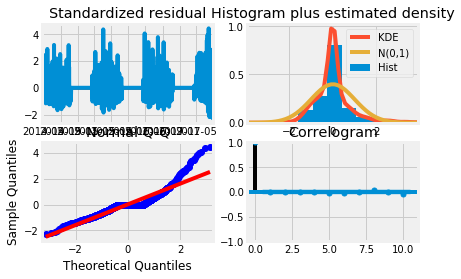

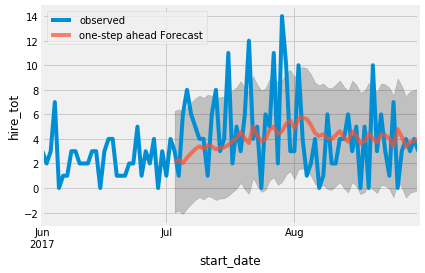

The Mean Squared Error of our forecasts is 10.76
The Root Mean Squared Error of our forecasts is 3.28


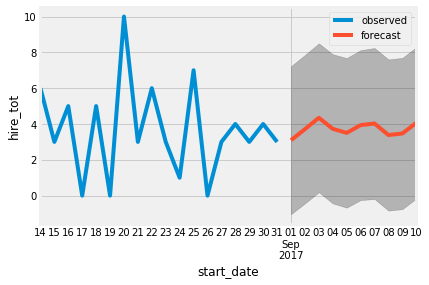

,lower hire_tot,upper hire_tot,mean hire_tot
2017-09-04,-0.43,7.89,3.73
2017-09-05,-0.67,7.68,3.50
2017-09-06,-0.25,8.12,3.94
2017-09-07,-0.19,8.24,4.03
2017-09-08,-0.84,7.61,3.38
2017-09-09,-0.75,7.69,3.47
2017-09-10,-0.16,8.29,4.07


In [16]:
for hire in ['hire_memb', 'hire_non', 'hire_tot']:
    print(hire)
    results = sarimax(hire)
    pred = validation_forecast(results, hire)
    mse_error(pred, hire)
    peform_forecast(results, hire)
    print('\n\n\n\n')

## Conclusion

We have peformed the forecast on daily time series which proves difficuly as there is much seasonal variation. Ideally we would want to bin by week or even month to have a more accurate prediction. The data itself had a lot of gaps which we have filled with NaNs on the assumption that there is no real difference either side of these regions. This is a big assumption but not doing this would make the problem intangible. It is better to have NaN than to assume zero hires in this time as this is misleading.

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.